In [1]:
from Environment import GridWorld
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import os

In [2]:
size = 10

In [3]:
env = GridWorld((size,size),0.2)
reward_grid = env.reset_Qlearning()
q_table = np.zeros((env.observation_space, env.action_space))

In [4]:
random.seed(0)

In [5]:
folder = "qlout"

In [6]:
try:
    os.mkdir(f'qlout/{size}')
except:
    pass

In [7]:
d = f'qlout/{size}/'

In [8]:
discount_factor = 0.9
num_episodes = 100000
max_steps_per_episode = reward_grid.shape[0] * reward_grid.shape[1] * 10
min_stepsl = []
converged = False
max_step = 0
# Convert grid-world positions to state indices
def state_to_index(state):
    return np.ravel_multi_index(state, dims=grid_world.shape)


def valid_actions(index,action):
    if action == 0:
        if index[0] == 0:
            return False
        else:
            return True
    elif action == 1:
        if index[0] == reward_grid.shape[0] - 1:
            return False
        else:
            return True
    elif action == 2:
        if index[1] == 0:
            return False
        else:
            return True
    elif action == 3:
        if index[1] == reward_grid.shape[1] - 1:
            return False
        else:
            return True
steps = []
rewards = []
min_steps = max_steps_per_episode
max_reward = 0
# Q-learning algorithm
for episode in range(num_episodes):
    exploration_prob = max(0.01, min(1, (1.0 - episode * 1/ num_episodes)*1))
    learning_rate = 0.0002
    state = (0, 0)
    grid_world = np.zeros(reward_grid.shape)
    grid_world[state] = 1
    state_index = state_to_index(state)
    done = False
    episode_reward = 0
    for step in range(max_steps_per_episode):
        # Epsilon-greedy policy for action selection
        reward = -0.05
        if random.uniform(0, 1) < exploration_prob:
            action = random.randint(0, 3)  # Exploration
        else:
            action = np.argmax(q_table[state_index, :])  # Exploitation
        if not valid_actions(state,action):
                reward += -0.5

        # Take the action and observe the next state and reward
        if action == 0:  # Up
            next_state = (max(0, state[0] - 1), state[1])
        elif action == 1:  # Down
            next_state = (min(grid_world.shape[0] - 1, state[0] + 1), state[1])
        elif action == 2:  # Left
            next_state = (state[0], max(0, state[1] - 1))
        else:  # Right
            next_state = (state[0], min(grid_world.shape[1] - 1, state[1] + 1))

        next_state_index = state_to_index(next_state)

        # Define rewards based on the grid-world environment
        if grid_world[next_state] == 0:
            reward += 1
            grid_world[next_state] = 1
        elif grid_world[next_state] == 1:
            reward +=  - 0.5
            #pass
        
        if grid_world.all() == 1:
            reward += 200 * (1 - step / max_steps_per_episode)
            if step < min_steps:
                min_stepsl.append(step)
                min_steps = step
            done = True

        # Q-value update using the Bellman equation
        q_table[state_index, action] = (1 - learning_rate) * q_table[state_index, action] + \
                                      learning_rate * (reward + discount_factor * np.max(q_table[next_state_index, :]))

        state = next_state
        state_index = next_state_index
        episode_reward += reward	
        if done:
            break
    steps.append(step+1)
    rewards.append(episode_reward)
    if episode_reward > max_reward:
        max_step = step+1
        max_reward = episode_reward
    #check if mean of last 100 episodes is greater than 195
    if episode > 100:
        if np.var(steps[-100:]) - np.var(steps[-200:-100]) < 1 and np.mean(steps[-100:]) - np.mean(steps[-200:-100]) < 1 and np.mean(steps[-100:]) < reward_grid.shape[0] * reward_grid.shape[1]  :
            converged = True
            break
    print(f"Episode {episode} completed with total reward {episode_reward:.2f} in {step+1} steps, max reward {max_reward:.2f} in {max_step} steps, exploration prob is {exploration_prob:.2f}                                              ", end='\r')



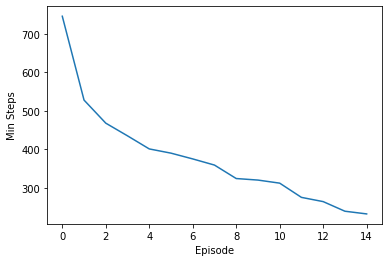

In [9]:
plt.plot(min_stepsl)
plt.xlabel('Episode')
plt.ylabel('Min Steps')
plt.savefig(f'{d}min_steps.png')

In [10]:
window_width = 100

In [11]:
cumsum_vec = np.cumsum(np.insert(steps, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

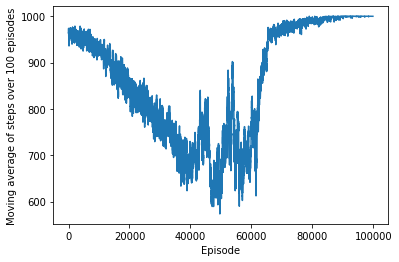

In [12]:
plt.plot(ma_vec)
plt.xlabel("Episode")
plt.ylabel("Moving average of steps over 100 episodes")
plt.savefig(f"{d}MA.png")

In [13]:
r = np.arange(1, 0, -1/num_episodes)

In [14]:
cumsum_vec = np.cumsum(np.insert(rewards, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

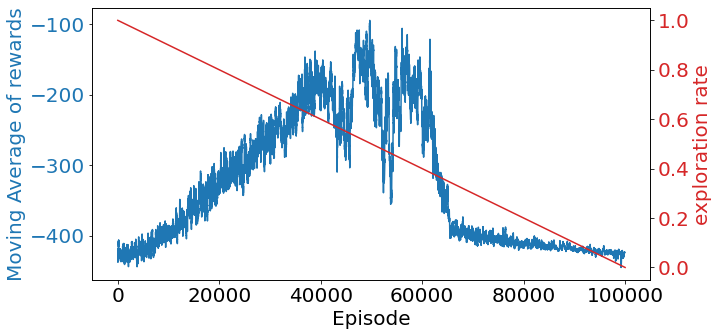

In [15]:
#plot ma and r
fig , ax1 = plt.subplots(figsize=(10,5))
color = 'tab:blue'
ax1.set_xlabel('Episode',fontsize=20)
ax1.set_ylabel('Moving Average of rewards', color=color,fontsize=20)
ax1.plot(ma_vec, color=color)
ax1.tick_params(axis='y', labelcolor=color,labelsize=20)
ax1.tick_params(axis='x',labelsize=20)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('exploration rate', color=color,fontsize=20)  # we already handled the x-label with ax1
ax2.plot(r, color=color)
ax2.tick_params(axis='y', labelcolor=color,labelsize=20)
plt.savefig(f"{d}MAR.png")



In [16]:
a = np.zeros(reward_grid.shape)
grid = np.zeros(reward_grid.shape)
arrows = []
init = (0,0)
a[init] = 1
step = 1
while step < grid.shape[0] * grid.shape[1]:
    action = np.argmax(q_table[state_to_index(init)])
    if action == 0:
        arrows.append((init, (0,-1)))
        init = (init[0]-1,init[1])
        
    elif action == 1:
        arrows.append((init, (0,1)))
        init = (init[0]+1,init[1])

    elif action == 2:
        arrows.append((init,(-1,0)))
        init = (init[0],init[1]-1)

    elif action == 3:
        arrows.append((init,(1,0)))

        init = (init[0],init[1]+1)

    a[init] = 1
    grid[init] = step
    step += 1


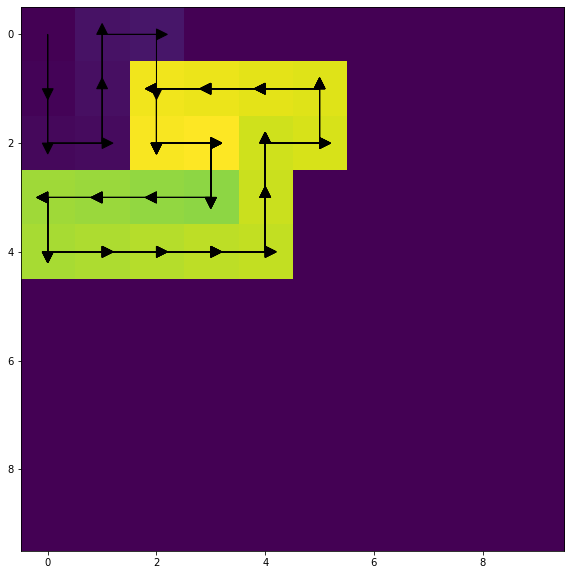

In [17]:
fig , ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
for arrow in arrows:
    ax.arrow(arrow[0][1],arrow[0][0],arrow[1][0],arrow[1][1],head_width=0.2, head_length=0.2, fc='k', ec='k')
plt.savefig(f"{d}Steps.png")


In [18]:
grid = np.zeros((2,2))
paths = []

1	1
2	2
3	8
4	52
5	824
6	22,144
7	1,510,446
8	180,160,012
9	54,986,690,944
10	29,805,993,260,994
11	41,433,610,713,353,366
12	103,271,401,574,007,978,038
13	660,340,630,211,753,942,588,170
14	7,618,229,614,763,015,717,175,450,784
15	225,419,381,425,094,248,494,363,948,728,158